### Assignement

We are given 10 basic explanatory variables, including passenger gender, age, and price of fare, among others.This is a classic binary classification problem, and we will be implementing a random forest classifer.

#### Importing Libraries

In [ ]:

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
%matplotlib inline

Loading Dataset of titanic

In [6]:
train = pd.read_csv(r'titanic\train.csv').set_index('PassengerId')
test = pd.read_csv(r'titanic\test.csv').set_index('PassengerId')
submission = pd.read_csv(r'titanic\gender_submission.csv')


EDA of Data

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


It appears that we can drop the `PassengerId` column, since it is merely an index. Note, however, that some people have reportedly improved their score with the `PassengerId` column. However, my cursory attempt to do so did not yield positive results, and moreover I would like to mimic a real-life scenario, where an index of a dataset generally has no correlation with the target variable.

In [8]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
train['Survived'].value_counts(normalize=True)
train['Survived'].groupby(train['Pclass']).mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

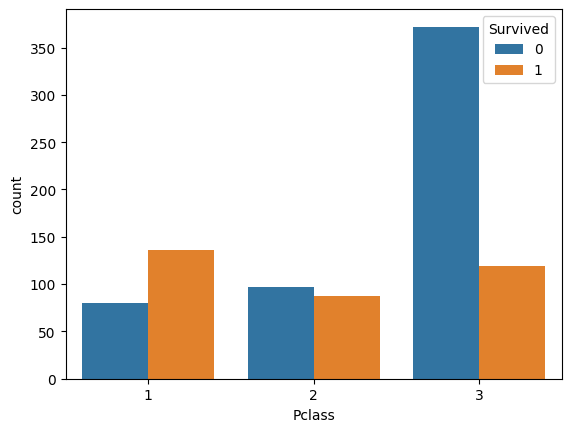

In [ ]:
# Ensuring that train is a DataFrame and has the required columns
sns.countplot(data=train, x='Pclass', hue='Survived')
plt.show()

First, we can obtain useful information about the passenger's title. Looking at the distribution of the titles, it might be useful to group the smaller sized values into an 'other' group, although I ultimately choose not to do this.

In [12]:
train['Name_Title'] = train['Name'].apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0])
train['Name_Title'].value_counts()

Name_Title
Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Mlle.          2
Major.         2
Col.           2
the            1
Capt.          1
Ms.            1
Sir.           1
Lady.          1
Mme.           1
Don.           1
Jonkheer.      1
Name: count, dtype: int64

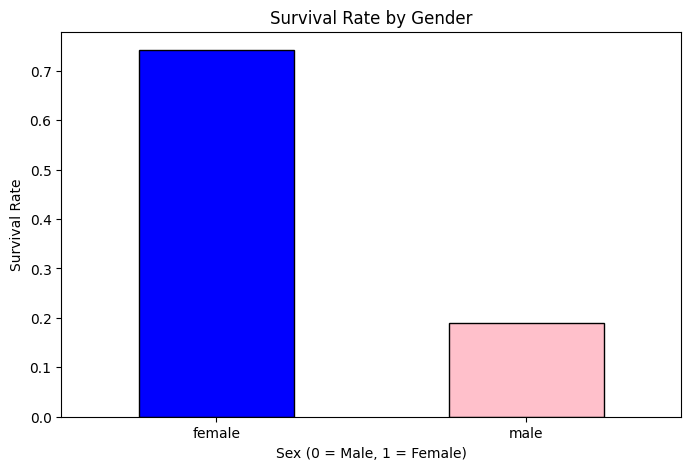

In [16]:

survival_by_gender = train['Survived'].groupby(train['Sex']).mean()
plt.figure(figsize=(8, 5))
survival_by_gender.plot(kind='bar', color=['blue', 'pink'], edgecolor='black')
plt.title('Survival Rate by Gender')
plt.xlabel('Sex (0 = Male, 1 = Female)')
plt.ylabel('Survival Rate')
plt.xticks(rotation=0)
plt.show()

## Age

There are 177 nulls for `Age`, and they have a 10% lower survival rate than the non-nulls. Before imputing values for the nulls, we will include an `Age_null` flag just to make sure we can account for this characteristic of the data. 

In [79]:
train['Survived'].groupby(train['Age'].isnull()).mean()

Age
False    0.406162
True     0.293785
Name: Survived, dtype: float64

Upon first glance, the relationship between age and survival appears to be a murky one at best. However, this doesn't mean that the variable will be a bad predictor; at deeper levels of a given decision tree, a more discriminant relationship might open up.

C:\Users\Javed\AppData\Local\Temp\ipykernel_29608\1943368582.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  survival_rates = train['Survived'].groupby(age_quantiles).mean()


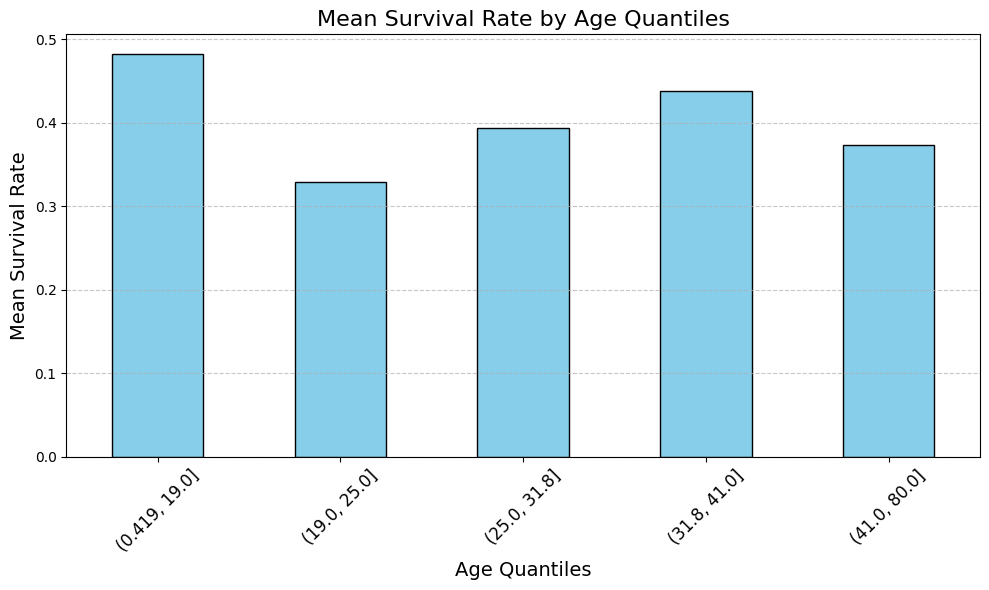

In [ ]:
age_quantiles = pd.qcut(train['Age'], 5)
survival_rates = train['Survived'].groupby(age_quantiles).mean()

# Plot the results
plt.figure(figsize=(10, 6))
survival_rates.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Mean Survival Rate by Age Quantiles', fontsize=16)
plt.xlabel('Age Quantiles', fontsize=14)
plt.ylabel('Mean Survival Rate', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Feature Engineering

Having done our cursory exploration of the variables, we now have a pretty good idea of how we want to transform our variables in preparation for our final dataset. We will perform our feature engineering through a series of helper functions that each serve a specific purpose. 

This first function creates two separate columns: a numeric column indicating the length of a passenger's `Name` field, and a categorical column that extracts the passenger's title.

In [19]:
def names(train, test):
    for i in [train, test]:
        i['Name_Len'] = i['Name'].apply(lambda x: len(x))
        i['Name_Title'] = i['Name'].apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0])
        del i['Name']
    return train, test

Next, we impute the null values of the `Age` column by filling in the mean value of the passenger's corresponding title and class. This more granular approach to imputation should be more accurate than merely taking the mean age of the population.

In [20]:
def age_impute(train, test):
    for i in [train, test]:
        i['Age_Null_Flag'] = i['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)
        data = train.groupby(['Name_Title', 'Pclass'])['Age']
        i['Age'] = data.transform(lambda x: x.fillna(x.mean()))
    return train, test

We combine the `SibSp` and `Parch` columns into a new variable that indicates family size, and group the family size variable into three categories.

In [21]:
def fam_size(train, test):
    for i in [train, test]:
        i['Fam_Size'] = np.where((i['SibSp']+i['Parch']) == 0 , 'Solo',
                           np.where((i['SibSp']+i['Parch']) <= 3,'Nuclear', 'Big'))
        del i['SibSp']
        del i['Parch']
    return train, test

The `Ticket` column is used to create two new columns: `Ticket_Lett`, which indicates the first letter of each ticket (with the smaller-n values being grouped based on survival rate); and `Ticket_Len`, which indicates the length of the `Ticket` field. 

In [22]:
def ticket_grouped(train, test):
    for i in [train, test]:
        i['Ticket_Lett'] = i['Ticket'].apply(lambda x: str(x)[0])
        i['Ticket_Lett'] = i['Ticket_Lett'].apply(lambda x: str(x))
        i['Ticket_Lett'] = np.where((i['Ticket_Lett']).isin(['1', '2', '3', 'S', 'P', 'C', 'A']), i['Ticket_Lett'],
                                   np.where((i['Ticket_Lett']).isin(['W', '4', '7', '6', 'L', '5', '8']),
                                            'Low_ticket', 'Other_ticket'))
        i['Ticket_Len'] = i['Ticket'].apply(lambda x: len(x))
        del i['Ticket']
    return train, test

The following two functions extract the first letter of the `Cabin` column and its number, respectively. 

In [23]:
def cabin(train, test):
    for i in [train, test]:
        i['Cabin_Letter'] = i['Cabin'].apply(lambda x: str(x)[0])
        del i['Cabin']
    return train, test

In [24]:
def cabin_num(train, test):
    for i in [train, test]:
        i['Cabin_num1'] = i['Cabin'].apply(lambda x: str(x).split(' ')[-1][1:])
        i['Cabin_num1'].replace('an', np.NaN, inplace = True)
        i['Cabin_num1'] = i['Cabin_num1'].apply(lambda x: int(x) if not pd.isnull(x) and x != '' else np.NaN)
        i['Cabin_num'] = pd.qcut(train['Cabin_num1'],3)
    train = pd.concat((train, pd.get_dummies(train['Cabin_num'], prefix = 'Cabin_num')), axis = 1)
    test = pd.concat((test, pd.get_dummies(test['Cabin_num'], prefix = 'Cabin_num')), axis = 1)
    del train['Cabin_num']
    del test['Cabin_num']
    del train['Cabin_num1']
    del test['Cabin_num1']
    return train, test

We fill the null values in the `Embarked` column with the most commonly occuring value, which is 'S.'

In [25]:
def embarked_impute(train, test):
    for i in [train, test]:
        i['Embarked'] = i['Embarked'].fillna('S')
    return train, test

We also fill in the one missing value of `Fare` in our test set with the mean value of `Fare` from the training set (transformations of test set data must always be fit using training data).

In [26]:
test['Fare'].fillna(train['Fare'].mean(), inplace = True)

C:\Users\Javed\AppData\Local\Temp\ipykernel_29608\3196480871.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test['Fare'].fillna(train['Fare'].mean(), inplace = True)


Next, because we are using scikit-learn, we must convert our categorical columns into dummy variables. The following function does this, and then it drops the original categorical columns. It also makes sure that each category is present in both the training and test datasets.

In [27]:
def dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked', 'Ticket_Lett', 'Cabin_Letter', 'Name_Title', 'Fam_Size']):
    for column in columns:
        train[column] = train[column].apply(lambda x: str(x))
        test[column] = test[column].apply(lambda x: str(x))
        good_cols = [column+'_'+i for i in train[column].unique() if i in test[column].unique()]
        train = pd.concat((train, pd.get_dummies(train[column], prefix = column)[good_cols]), axis = 1)
        test = pd.concat((test, pd.get_dummies(test[column], prefix = column)[good_cols]), axis = 1)
        del train[column]
        del test[column]
    return train, test

Our last helper function drops any columns that haven't already been dropped. In our case, we only need to drop the `PassengerId` column, which we have decided is not useful for our problem (by the way, I've confirmed this with a separate test). Note that dropping the `PassengerId` column here means that we'll have to load it later when creating our submission file.

In [28]:
def drop(train, test, bye = ['PassengerId']):
    for i in [train, test]:
        for z in bye:
            del i[z]
    return train, test

Having built our helper functions, we can now execute them in order to build our dataset that will be used in the model:a

In [30]:
train = pd.read_csv(r'titanic\train.csv')
test = pd.read_csv(r'titanic\test.csv')
train, test = names(train, test)
train, test = age_impute(train, test)
train, test = cabin_num(train, test)
train, test = cabin(train, test)
train, test = embarked_impute(train, test)
train, test = fam_size(train, test)
test['Fare'].fillna(train['Fare'].mean(), inplace = True)
train, test = ticket_grouped(train, test)
train, test = dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked', 'Ticket_Lett',
                                                                     'Cabin_Letter', 'Name_Title', 'Fam_Size'])
train, test = drop(train, test)

C:\Users\Javed\AppData\Local\Temp\ipykernel_29608\628700535.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  i['Cabin_num1'].replace('an', np.NaN, inplace = True)
C:\Users\Javed\AppData\Local\Temp\ipykernel_29608\628700535.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

We can see that our final dataset has 45 columns, composed of our target column and 44 predictor variables. Although highly dimensional datasets can result in high variance, I think we should be fine here. 

In [31]:
print(len(train.columns))

45


### Hyperparameter Tuning

I have used used grid search to identify the optimal parameters of our random forest model. Because our training dataset is quite small, we can get away with testing a wider range of hyperparameter values. When I ran this on my 8 GB Windows machine, the process took less than ten minutes. I will not run it here for the sake of saving myself time, but I will discuss the results of this grid search.

from sklearn.model_selection import GridSearchCV  
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)

param_grid = { "criterion"   : ["gini", "entropy"],
             "min_samples_leaf" : [1, 5, 10],
             "min_samples_split" : [2, 4, 10, 12, 16],
             "n_estimators": [50, 100, 400, 700, 1000]}

gs = GridSearchCV(estimator=rf,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=3,
                  n_jobs=-1)

gs = gs.fit(train.iloc[:, 1:], train.iloc[:, 0])

print(gs.best_score_)   
print(gs.best_params_)  
print(gs.cv_results_)

Looking at the results of the grid search:  

0.838383838384  
{'min_samples_split': 10, 'n_estimators': 700, 'criterion': 'gini', 'min_samples_leaf': 1}  

...we can see that our optimal parameter settings are not at the endpoints of our provided values, meaning that we do not have to test more values. What else can we say about our optimal values? The `min_samples_split` parameter is at 10, which should help mitigate overfitting to a certain degree. This is especially good because we have a relatively large number of estimators (700), which could potentially increase our generalization error.

### Model Estimation and Evaluation<a name="model"></a>

We are now ready to fit our model using the optimal hyperparameters. The out-of-bag score can give us an unbiased estimate of the model accuracy, and we can see that the score is 82.94%, which is only a little higher than our final leaderboard score.

In [32]:
from sklearn.ensemble import RandomForestClassifier

# Correct max_features parameter
rf = RandomForestClassifier(
    criterion='gini', 
    n_estimators=700,
    min_samples_split=10,
    min_samples_leaf=1,
    max_features='sqrt', 
    oob_score=True,
    random_state=1,
    n_jobs=-1
)

# Fit the model
rf.fit(train.iloc[:, 1:], train.iloc[:, 0])

# Print the out-of-bag score
print("OOB Score: %.4f" % rf.oob_score_)


OOB Score: 0.8294


Let's take a brief look at our variable importance according to our random forest model. We can see that some of the original columns we predicted would be important in fact were, including gender, fare, and age. But we also see title, name length, and ticket length feature prominently, so we can pat ourselves on the back for creating such useful variables.

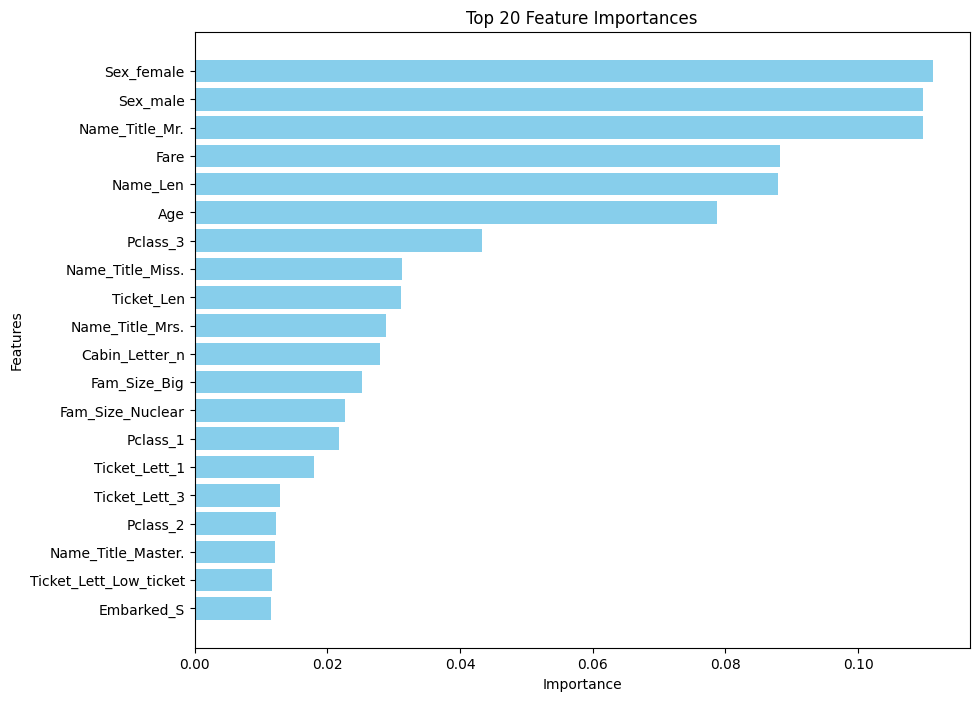

In [36]:
feature_importance_df = pd.concat(
    (pd.DataFrame(train.iloc[:, 1:].columns, columns=['variable']),
     pd.DataFrame(rf.feature_importances_, columns=['importance'])),
    axis=1
).sort_values(by='importance', ascending=False)[:20]
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['variable'], feature_importance_df['importance'], color='skyblue')
plt.gca().invert_yaxis()  # To show the highest importance at the top
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


Our last step is to predict the target variable for our test data and generate an output file that will be submitted to Kaggle. 

In [ ]:
predictions = rf.predict(test)
predictions = pd.DataFrame(predictions, columns=['Survived'])
test = pd.read_csv(r'titanic\test.csv')
predictions = pd.concat([test['PassengerId'], predictions], axis=1)
# Save predictions to CSV
predictions.to_csv('y_test15.csv', sep=",", index=False)
